In [1]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import MathsUtilities as MUte
import matplotlib.dates as mdates
%matplotlib inline

Lines = ['-','-','-','--','--','--']
Colors = ['r','b','g','r','b','g']
Fills = ['r','b','g','w','w','w']

Crops = ['Maize','Wheat']

## Get Wheat Data

In [2]:
con = sqlite3.connect('D:\GitHubRepos\ApsimX\Tests\Validation\Wheat/Wheat.db')
WheatPredicted = pd.read_sql("Select * from DailyReport where Zone = 'RainShelter'",
                        con)
WheatPredicted.ix[:,'Clock.Today'] = pd.to_datetime(WheatPredicted.ix[:,'Clock.Today']) 
WheatObserved = pd.read_sql("Select * from Observed where SimulationName Like '%Lincoln2015%'", 
                           con)

WheatIrrigs = ['Full','Nil']
WheatNs = ['0','50','250']
WheatIrrigs2 = ['IrrFull','IrrNil']
WheatNs2 = ['Nit0','Nit50','Nit250']
WheatTreats = []
for Irrig in WheatIrrigs2:
    for Nit in WheatNs2:
        WheatTreats.append(Nit+Irrig)

## Get Maize Data

In [3]:
con = sqlite3.connect('D:\GitHubRepos\ApsimX\Tests\Validation\Maize/Maize.db')
MaizePredicted = pd.read_sql("Select * from Report where Zone = 'RainShelter'",
                        con)
MaizePredicted.ix[:,'Clock.Today'] = pd.to_datetime(MaizePredicted.ix[:,'Clock.Today'])
MaizeObserved = pd.read_sql("Select * from Observed where SimulationName Like '%Lincoln2012%'", 
                           con)
MaizeIrrigs = ['Full','Nil']
MaizeNs = ['Nil','Low','Med']
MaizeIrrigs2 = ['IrrFull','IrrNil']
MaizeNs2 = ['NitNil','NitLow','NitMed']
MaizeTreats = []
for Irrig in MaizeIrrigs2:
    for Nit in MaizeNs2:
        MaizeTreats.append(Nit+Irrig)

In [4]:
Obs = WheatObserved.ix[:,'Wheat.AboveGround.Wt'].dropna()
Pred = pd.DataFrame(index = Obs.index, columns = ['Wheat.AboveGround.Wt'])
for observation in Obs.index:
    Treat = WheatObserved.ix[observation,'SimulationName'][14:].split('Irr')
    Nit = Treat[0]
    Irr = Treat[1]
    Date = pd.to_datetime(WheatObserved.ix[observation, 'Clock.Today'])
    MatchPredFilter = (WheatPredicted.ix[:,'Nit'] == Nit) & (WheatPredicted.ix[:,'Irr'] == Irr) & (WheatPredicted.ix[:,'Clock.Today'] == Date)
    Pred.ix[observation,'Wheat.AboveGround.Wt'] = WheatPredicted.ix[MatchPredFilter,'Wheat.AboveGround.Wt'].values[0]

In [5]:
def ObsPredTimeSeries(Variable,rows,row,ymax,ylab,TextX,TextY):
    pan = 1
    for Crop in Crops:
        axis = Graph.add_subplot(rows,2,row*2+pan)
        pos = 0
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                Pred = Predicted.ix[PredFilter,Crop+'.'+Variable]
                Pred = Pred.ix[Pred>0]
                #PredIndex = pd.to_datetime(Predicted.ix[PredFilter,'Clock.Today'])
                PredIndex = pd.to_datetime(Predicted.ix[Pred.index,'Clock.Today'])
                plt.plot(PredIndex,Pred,Lines[pos],color=Colors[pos],lw=5)

                ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
                Obs = Observed.ix[ObsFilter,Crop+'.'+Variable]
                ObsIndex = pd.to_datetime(Observed.ix[ObsFilter,'Clock.Today'])
                plt.plot(ObsIndex,Obs,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
                pos +=1
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        if rows == row + 1:
            xlabON = 'on'
            axis.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
            plt.xticks(rotation=45)
        else:
            xlabON =  'off'
        plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off', labelbottom=xlabON)
        if pan == 1:
            ylabON = 'on'
            plt.ylabel(ylab,fontsize=16)
        if pan == 2:
            ylabON = 'off'
        plt.tick_params(axis='y', length = 10, width = 3,direction = 'inout',left='on',right='off',labelleft = ylabON, labelright='off')
        plt.ylim(0,ymax)
        xpos = pd.to_datetime(Predicted.ix[:,'Clock.Today'].min())# + (pd.to_datetime(Predicted.ix[:,'Clock.Today'].max()) - pd.to_datetime(Predicted.ix[:,'Clock.Today'].min()))/2
        plt.title(Crop + '.' + Variable,fontsize=16)
        
        Obs = Observed.ix[:,Crop+'.'+Variable].dropna()
        PredObs = pd.DataFrame(index = Obs.index, columns = ['Pred','Obs'])
        PredObs.ix[:,'Obs'] = Obs
        for observation in PredObs.index:
            Treat = Observed.ix[observation,'SimulationName'][14:].split('Irr')
            Nit = Treat[0]
            Irr = Treat[1]
            Date = pd.to_datetime(Observed.ix[observation, 'Clock.Today'])
            MatchFilter = (Predicted.ix[:,'Nit'] == Nit) & (Predicted.ix[:,'Irr'] == Irr) & (Predicted.ix[:,'Clock.Today'] == Date)
            PredObs.ix[observation,'Pred'] = Predicted.ix[MatchFilter,Crop+'.'+Variable].values[0]
        RegStats = MUte.MathUtilities.CalcRegressionStats(Variable,PredObs.Pred.values,PredObs.Obs.values)
        LabelText = '   RMSE = ' + '%.2f'%RegStats.RMSE +'\n   NSE = ' + '%.2f'%RegStats.NSE
        plt.text(TextX,TextY,LabelText,transform=axis.transAxes,fontsize=11)
        
        pos = 0
        pan +=1

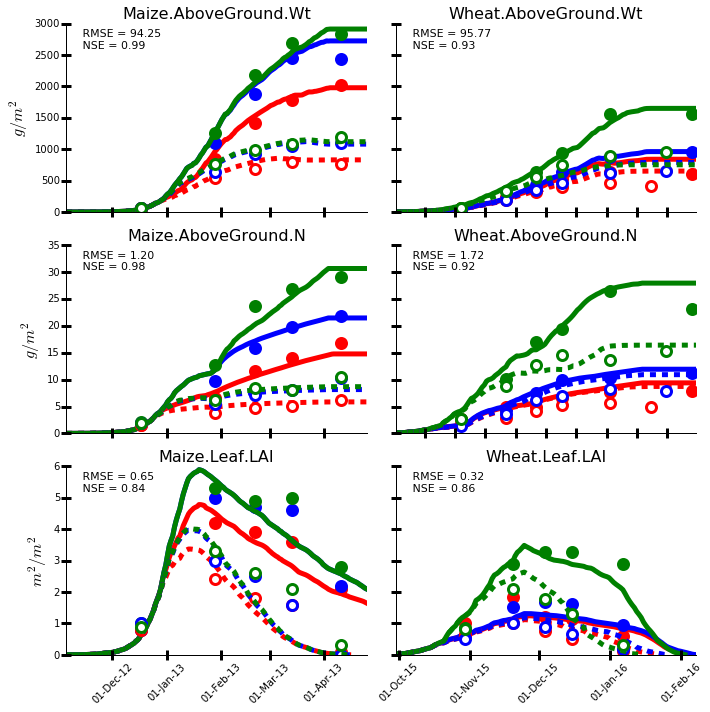

In [6]:
Graph = plt.figure(figsize=(10,10))
cols = 3
ObsPredTimeSeries('AboveGround.Wt',cols,0,3000, '$g/m^2$',0.02,0.87)
ObsPredTimeSeries('AboveGround.N',cols,1,35,'$g/m^2$',0.02,0.87)
ObsPredTimeSeries('Leaf.LAI',cols,2,6,'$m^2/m^2$',0.02,0.87)
Graph.tight_layout()

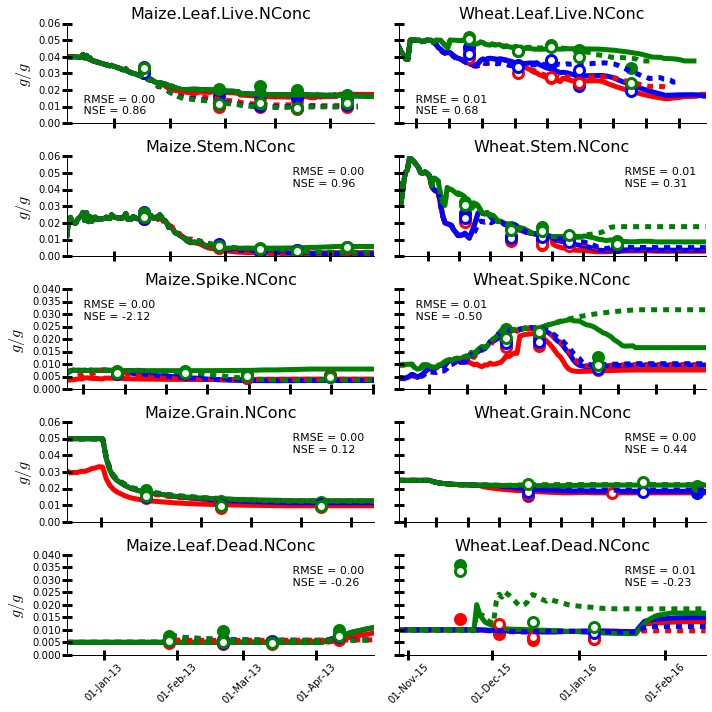

In [7]:
Graph = plt.figure(figsize=(10,10))
cols = 5
ObsPredTimeSeries('Leaf.Live.NConc',cols,0,0.06,'$g/g$',0.02,.1)
ObsPredTimeSeries('Stem.NConc',cols,1,0.06,'$g/g$',0.7,.7)
ObsPredTimeSeries('Spike.NConc',cols,2,0.04,'$g/g$',0.02,.7)
ObsPredTimeSeries('Grain.NConc',cols,3,0.06,'$g/g$',0.7,.7)
ObsPredTimeSeries('Leaf.Dead.NConc',cols,4,0.04,'$g/g$',0.7,.7)
Graph.tight_layout()

In [8]:
def ObsPredDMPropVTime(Variable,rows,row,ymax,ylab):
    pan = 1
    for Crop in Crops:
        axis = Graph.add_subplot(rows,2,row*2+pan)
        pos = 0
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        TotalVal = Crop+'.AboveGround.'+Variable.split('.')[-1:][0]
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                TotalDMPred = Predicted.ix[PredFilter,TotalVal]
                ComponentDMPred = Predicted.ix[PredFilter,Crop+'.'+Variable]/TotalDMPred
                PredIndex = pd.to_datetime(Predicted.ix[PredFilter,'Clock.Today'])
                plt.plot(PredIndex,ComponentDMPred,Lines[pos],color=Colors[pos],lw=2)

                ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
                TotalDMObs = Observed.ix[ObsFilter,TotalVal]
                ComponentDMObs = Observed.ix[ObsFilter,Crop+'.'+Variable]/TotalDMObs
                ObsIndex = pd.to_datetime(Observed.ix[ObsFilter,'Clock.Today'])
                plt.plot(ObsIndex,ComponentDMObs,'.',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=15,mew=3)
                pos +=1
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        if rows == row + 1:
            xlabON = 'on'
            axis.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
            plt.xticks(rotation=45)
        else:
            xlabON =  'off'
        plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off', labelbottom=xlabON)
        if pan == 1:
            ylabON = 'on'
            plt.ylabel(ylab,fontsize=12)
        if pan == 2:
            ylabON = 'off'
        plt.tick_params(axis='y', length = 10, width = 3,direction = 'inout',left='on',right='off',labelleft = ylabON, labelright='off')
        plt.ylim(0,ymax)
        xpos = pd.to_datetime(Predicted.ix[:,'Clock.Today'].min())# + (pd.to_datetime(Predicted.ix[:,'Clock.Today'].max()) - pd.to_datetime(Predicted.ix[:,'Clock.Today'].min()))/2
        plt.title(Crop + '.' + Variable,fontsize=16)
        
        TotalDMObs = Observed.ix[:,TotalVal].dropna()
        Obs = Observed.ix[:,Crop+'.'+Variable].dropna()/TotalDMObs
        PredObs = pd.DataFrame(index = Obs.index, columns = ['Pred','Obs'])
        PredObs.ix[:,'Obs'] = Obs
        for observation in PredObs.index:
            Treat = Observed.ix[observation,'SimulationName'][14:].split('Irr')
            Nit = Treat[0]
            Irr = Treat[1]
            Date = pd.to_datetime(Observed.ix[observation, 'Clock.Today'])
            MatchFilter = (Predicted.ix[:,'Nit'] == Nit) & (Predicted.ix[:,'Irr'] == Irr) & (Predicted.ix[:,'Clock.Today'] == Date)
            PredObs.ix[observation,'Pred'] = Predicted.ix[MatchFilter,Crop+'.'+Variable].values[0]/Predicted.ix[MatchFilter,TotalVal].values[0]
        RegStats = MUte.MathUtilities.CalcRegressionStats(Variable,PredObs.Pred.values,PredObs.Obs.values)
        LabelText = '   RMSE = ' + '%.2f'%RegStats.RMSE +'\n   NSE = ' + '%.2f'%RegStats.NSE
        plt.text(axis.get_xlim()[0],ymax*.5,LabelText)
        
        pos = 0
        pan +=1

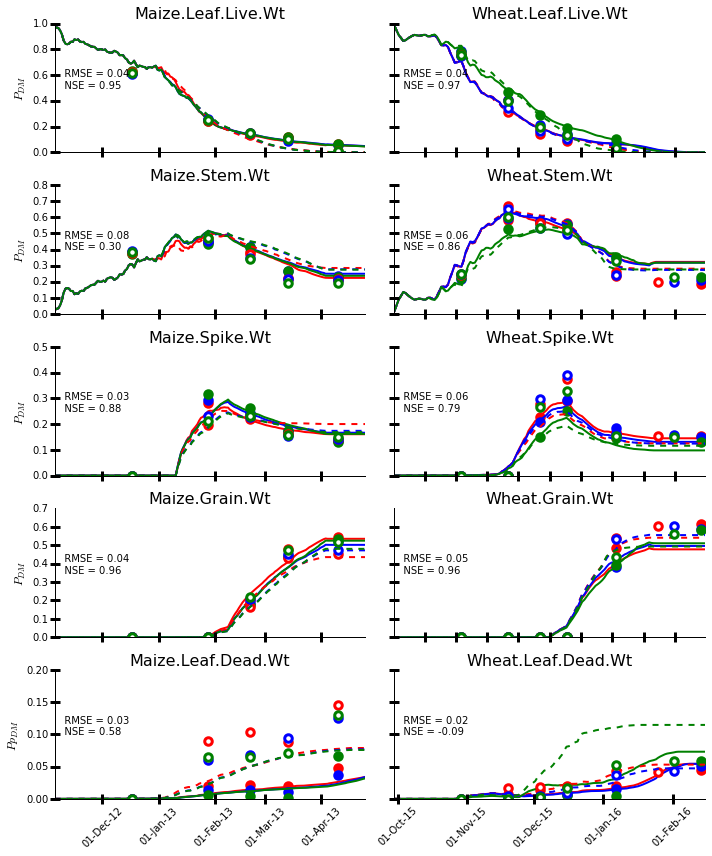

In [9]:
Graph = plt.figure(figsize=(10,12))
cols = 5
ObsPredDMPropVTime('Leaf.Live.Wt',cols,0,1,r'$P_{DM}$')
ObsPredDMPropVTime('Stem.Wt',cols,1,.8,r'$P_{DM}$')
ObsPredDMPropVTime('Spike.Wt',cols,2,.5,r'$P_{DM}$')
ObsPredDMPropVTime('Grain.Wt',cols,3,0.7,r'$P_{DM}$')
ObsPredDMPropVTime('Leaf.Dead.Wt',cols,4,0.2,r'$Pp_{DM}$')
Graph.tight_layout()

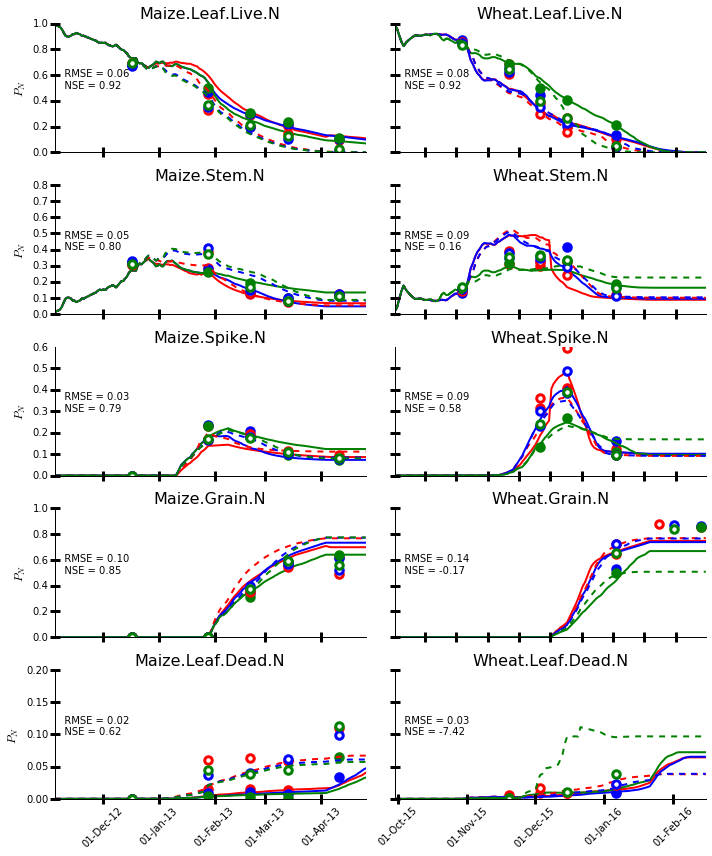

In [10]:
Graph = plt.figure(figsize=(10,12))
cols = 5
ObsPredDMPropVTime('Leaf.Live.N',cols,0,1,r'$P_{N}$')
ObsPredDMPropVTime('Stem.N',cols,1,.8,r'$P_{N}$')
ObsPredDMPropVTime('Spike.N',cols,2,0.6,r'$P_{N}$')
ObsPredDMPropVTime('Grain.N',cols,3,1.0,r'$P_{N}$')
ObsPredDMPropVTime('Leaf.Dead.N',cols,4,0.2,r'$P_{N}$')
Graph.tight_layout()

In [11]:
def regression_comp(xVar,yVar,xmax,ymax,rows,pan,xSer,yLemWheat,yLemMaize):
    for Crop in Crops:
        Graph.add_subplot(rows,2,pan)
        pos = 0
        if Crop == 'Wheat':
            plt.plot(xSer,yLemWheat,'-',color='k',lw=5)
        else:
            plt.plot(xSer,yLemMaize,'-',color='k',lw=5)
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                xPred = Predicted.ix[PredFilter,Crop+xVar]
                yPred = Predicted.ix[PredFilter,Crop+yVar]
                plt.plot(xPred,yPred,Lines[pos],color=Colors[pos],lw=5)

                ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
                xObs = Observed.ix[ObsFilter,Crop+xVar]
                yObs = Observed.ix[ObsFilter,Crop+yVar]
                plt.plot(xObs,yObs,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
                pos +=1
        plt.ylim(0,ymax)
        plt.xlim(0,xmax)
        pan +=1
    return pan

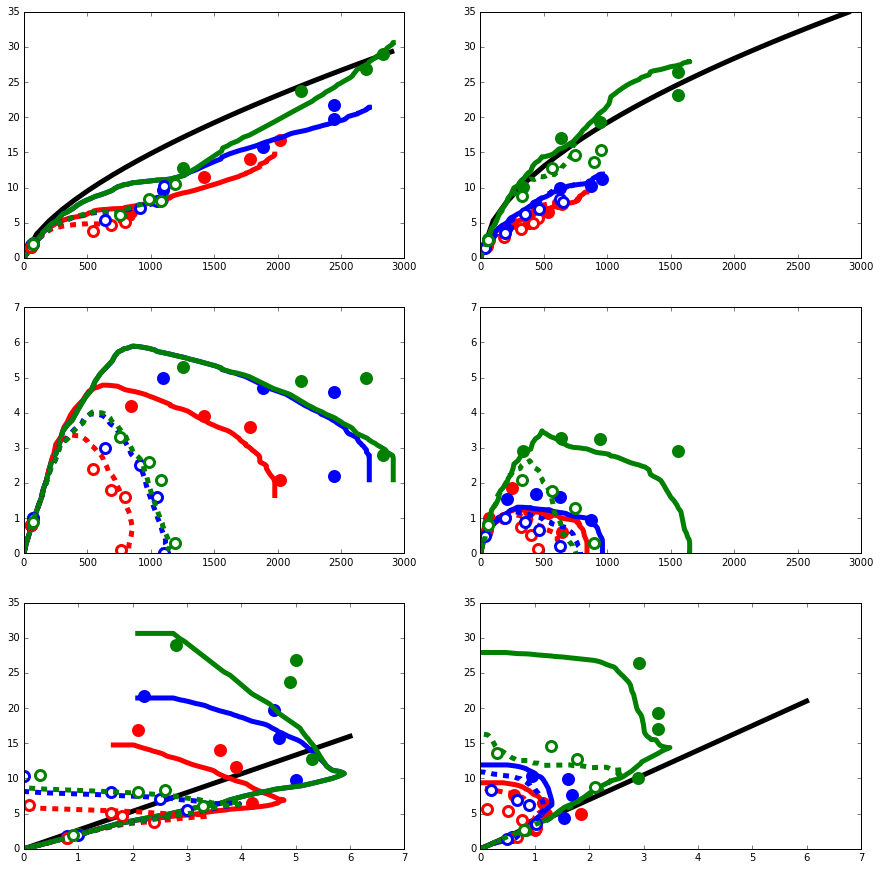

In [12]:
Graph = plt.figure(figsize=(15,15))
pan = 1
xSer = range(30)
yLemWheat = np.divide(np.multiply(53,np.power(xSer,0.56)),10)
yLemMaize = np.divide(np.multiply(34,np.power(xSer,0.64)),10)
xSer = np.multiply(xSer,100)
pan = regression_comp('.AboveGround.Wt','.AboveGround.N',3000,35,3,pan,xSer,yLemWheat,yLemMaize)
pan = regression_comp('.AboveGround.Wt','.Leaf.LAI',3000,7,3,pan,[],[],[])
xSer = [0,6]
yLemWheat = np.divide([0,6*36],10)
yLemMaize = np.divide([0,6*28],10)
pan = regression_comp('.Leaf.LAI','.AboveGround.N',7,35,3,pan,xSer,yLemWheat,yLemMaize)


In [13]:
MaizeObserved.ix[3,'Maize.Leaf.LAI'] = np.nan
MaizeObserved.ix[:,"Maize.Leaf.SpecificArea"] = (MaizeObserved.ix[:,'Maize.Leaf.LAI']*1000000)/MaizeObserved.ix[:,'Maize.Leaf.Live.Wt']
WheatObserved.ix[:,"Wheat.Leaf.SpecificArea"] = (WheatObserved.ix[:,'Wheat.Leaf.LAI']*1000000)/WheatObserved.ix[:,'Wheat.Leaf.Live.Wt']
MaizeObserved.ix[:,"Maize.Leaf.SpecificNitrogen"] = MaizeObserved.ix[:,'Maize.Leaf.Live.N']/MaizeObserved.ix[:,'Maize.Leaf.LAI']
WheatObserved.ix[:,"Wheat.Leaf.SpecificNitrogen"] = WheatObserved.ix[:,'Wheat.Leaf.Live.N']/WheatObserved.ix[:,'Wheat.Leaf.LAI']

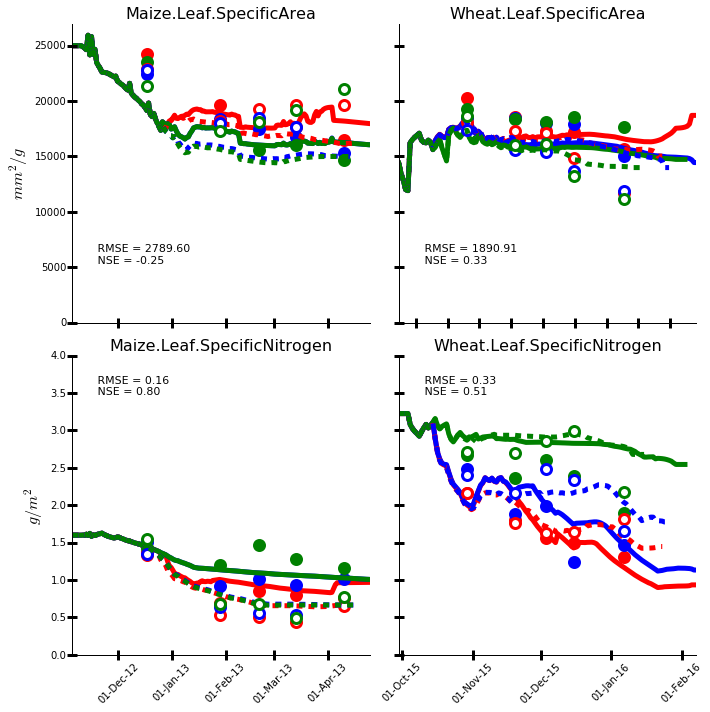

In [14]:
Graph = plt.figure(figsize=(10,10))
cols = 2
ObsPredTimeSeries('Leaf.SpecificArea',cols,0,27000,r'$mm^2/g$',.05,.2)
ObsPredTimeSeries('Leaf.SpecificNitrogen',cols,1,4,r'$g/m^2$',.05,.87)
Graph.tight_layout()

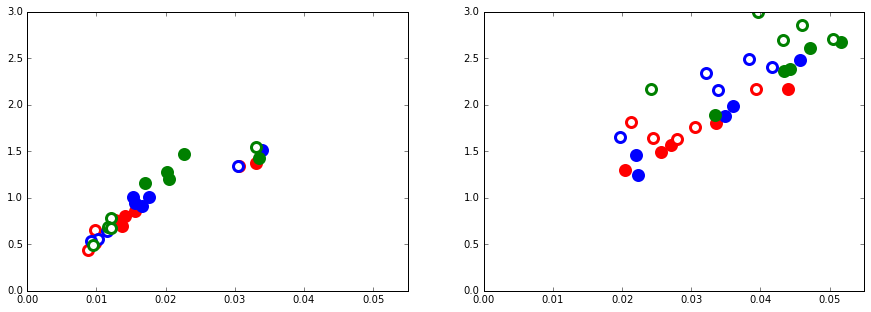

In [15]:
Graph = plt.figure(figsize=(15,5))
pan = 1
for Crop in Crops:
    Graph.add_subplot(1,2,pan)
    pos = 0
    Predicted = globals()[Crop+'Predicted']
    Observed = globals()[Crop+'Observed']
    Treats = globals()[Crop+'Treats']
    Irrigs = globals()[Crop+'Irrigs']
    Ns = globals()[Crop+'Ns']
    for Irrig in Irrigs:
        for N in Ns:
            ObsFilter = [Treats[pos] in Observed.SimulationName[x] for x in Observed.index]
            SLN = Observed.ix[ObsFilter,Crop+'.Leaf.SpecificNitrogen']
            LN = Observed.ix[ObsFilter,Crop+'.Leaf.Live.NConc']
            plt.plot(LN,SLN,'o',color=Colors[pos],mec=Colors[pos],mfc=Fills[pos],markersize=10,mew=3)
            pos +=1
    plt.ylim(0,3)
    plt.xlim(0,.055)
    pan +=1

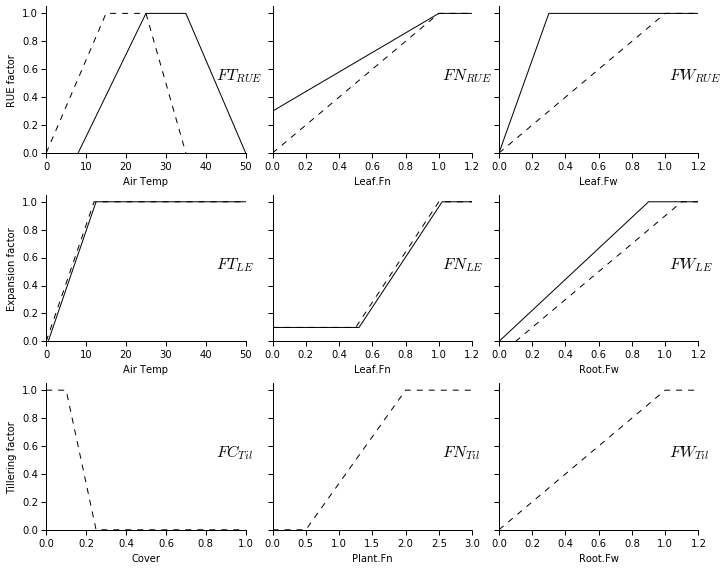

In [16]:
def ParamPlot(Tit,xName,yName,xM,yM,xW,yW,pan):
    axis = Graph.add_subplot(3,3,pan)
    plt.plot(xM,yM,'-',color='k')
    plt.plot(xW,yW,'--',color='k')
    plt.ylim(0,1.05)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    ylabON = 'off'
    if (pan == 1) | (pan == 4) | (pan == 7):
        plt.ylabel(yName)
        ylabON = 'on'
    #if pan <= 3:
    #    xlabON = 'off'
    #else:
    xlabON = 'on'
    plt.xlabel(xName)
    plt.tick_params(axis='x', length = 5, width = 1,direction = 'out',bottom='on',top='off', labelbottom=xlabON)
    plt.tick_params(axis='y', length = 5, width = 1,direction = 'out',left='on',right='off',labelleft = ylabON, labelright='off')
    plt.text(0.85,0.5,Tit,transform=axis.transAxes, fontsize=16)

Graph = plt.figure(figsize = (10,8))
ParamPlot(r'$FT_{RUE}$', 'Air Temp','RUE factor',[8,25,35,50],[0,1,1,0],[0,15,25,35],[0,1,1,0],1)
ParamPlot(r'$FN_{RUE}$','Leaf.Fn','RUE factor',[0,1,1.2],[0.3,1,1],[0,1,1.2],[0,1,1],2)
ParamPlot(r'$FW_{RUE}$','Leaf.Fw','RUE factor',[0,0.3,1.2],[0,1,1],[0,1,1.2],[0,1,1],3)
ParamPlot(r'$FT_{LE}$','Air Temp','Expansion factor',[0.5,12.5,50],[0,1,1],[0,12,50],[0,1,1,],4)
ParamPlot(r'$FN_{LE}$','Leaf.Fn','Expansion factor',[0,0.52,1.02,1.2],[0.1,0.1,1,1],[0,0.5,1,1.2],[0.1,0.1,1,1],5)
ParamPlot(r'$FW_{LE}$','Root.Fw','Expansion factor',[0,0.9,1.2],[0,1,1],[0.1,1.1,1.2],[0,1,1],6)
ParamPlot(r'$FC_{Til}$','Cover','Tillering factor',[0,0.1,0.25],[0,0,0],[0,0.1,0.25,1],[1,1,0,0],7)
ParamPlot(r'$FN_{Til}$','Plant.Fn','Tillering factor',[0.5,2,3],[0,0,0],[0,0.5,2,3],[0,0,1,1],8)
ParamPlot(r'$FW_{Til}$','Root.Fw','Tillering factor',[0,1,1.2],[0,0,0],[0,1,1.2],[0,1,1],9)
Graph.tight_layout()

In [17]:
def PredTimeSeries(Variable,rows,row,ymax):
    pan = 1
    for Crop in Crops:
        axis = Graph.add_subplot(rows,2,row*2+pan)
        pos = 0
        Predicted = globals()[Crop+'Predicted']
        Observed = globals()[Crop+'Observed']
        Treats = globals()[Crop+'Treats']
        Irrigs = globals()[Crop+'Irrigs']
        Ns = globals()[Crop+'Ns']
        for Irrig in Irrigs:
            for N in Ns:
                PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
                Pred = Predicted.ix[PredFilter,Crop+'.'+Variable]
                PredIndex = pd.to_datetime(Predicted.ix[PredFilter,'Clock.Today'])
                plt.plot(PredIndex,Pred,Lines[pos],color=Colors[pos],lw=5)
                pos +=1
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        if rows == row + 1:
            xlabON = 'on'
            axis.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
            plt.xticks(rotation=45)
        else:
            xlabON =  'off'
        plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off', labelbottom=xlabON)
        if pan == 1:
            ylabON = 'on'
        if pan == 2:
            ylabON = 'off'
        plt.tick_params(axis='y', length = 10, width = 3,direction = 'inout',left='on',right='off',labelleft = ylabON, labelright='off')
        plt.ylim(0,ymax)
        xpos = pd.to_datetime(Predicted.ix[:,'Clock.Today'].min())# + (pd.to_datetime(Predicted.ix[:,'Clock.Today'].max()) - pd.to_datetime(Predicted.ix[:,'Clock.Today'].min()))/2
        plt.title(Crop + '.' + Variable,fontsize=16)
        pos = 0
        pan +=1

<function matplotlib.pyplot.tight_layout>

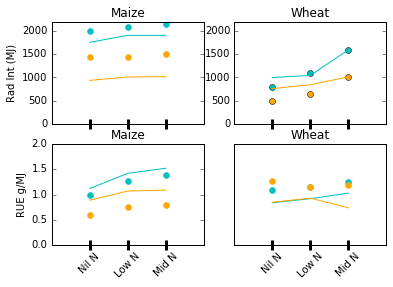

In [18]:
xPos = [1,2,3]
Graph = plt.figure()
#Radiation Interception
axis = Graph.add_subplot(2,2,1)
plt.title('Maize')
#Irrigated Maize
    #Observed
plt.plot(xPos,[2000,2100,2150],'o',mec='c',mfc='c')
    #predicted
plt.plot(xPos,[1762,1914,1914],'-',color = 'c')
#UnIrrigated Maize
    #Observed
plt.plot(xPos,[1450,1450,1500],'o',mec='orange',mfc='orange')
    #predicted
plt.plot(xPos,[937,1011,1017],'-',color = 'orange')
plt.ylim(0,2200)
plt.xlim(0,4)
axis.set_xticks([1, 2, 3])
plt.ylabel('Rad Int (MJ)')
plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off',labeltop = 'off', labelbottom='off')

axis = Graph.add_subplot(2,2,2)
plt.title('Wheat')
#Irrigated Wheat
    #Observed
plt.plot(xPos,[800,1100,1600],'o',color='c')
    #Predicted
plt.plot(xPos,[999,1046,1601],'-',color='c')   
#UnIrrigated Wheat
    #Observed
plt.plot(xPos,[500,650,1000],'o',color='orange')
    #Predicted
plt.plot(xPos,[759,842,1015],'-',color='orange')    
plt.ylim(0,2200)
plt.xlim(0,4)
axis.set_xticks([1, 2, 3])
plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off',labeltop = 'off', labelbottom='off')
#Radiation Use Efficiency

axis = Graph.add_subplot(2,2,3)
plt.title('Maize')
#Irrigated Maize
    #Observed
plt.plot(xPos,[1.0,1.27,1.39],'o',mec='c',mfc='c')
    #predicted
plt.plot(xPos,[1.12,1.42,1.52],'-',color = 'c')
#UnIrrigated Maize
    #Observed
plt.plot(xPos,[.59,.75,.8],'o',mec='orange',mfc='orange')
    #predicted
plt.plot(xPos,[.89,1.07,1.09],'-',color = 'orange')
plt.ylim(0,2)
plt.xlim(0,4)
plt.ylabel('RUE g/MJ')
axis.set_xticks([1, 2, 3])
plt.xticks(xPos, ['Nil N','Low N','Mid N'], rotation=45)
plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off',labeltop = 'off', labelbottom='on')

axis = Graph.add_subplot(2,2,4)
plt.title('Wheat')
#Irrigated Wheat
    #Observed
plt.plot(xPos,[1.1,1.15,1.25],'o',mec='c',mfc='c')
    #predicted
plt.plot(xPos,[0.84,0.92,1.03],'-',color = 'c')
#UnIrrigated Wheat
    #Observed
plt.plot(xPos,[1.27,1.15,1.18],'o',mec='orange',mfc='orange')
    #predicted
plt.plot(xPos,[.85,0.93,0.74],'-',color = 'orange')
plt.ylim(0,2)
plt.xlim(0,4)
axis.set_xticks([1, 2, 3])
plt.tick_params(axis='x', length = 10, width = 3,direction = 'inout',bottom='on',top='off',labeltop = 'off', labelbottom='on')
plt.tick_params(axis='y', length = 10, width = 3,direction = 'inout',left='off',right='off',labelleft = 'off', labelright='off')
plt.xticks(xPos, ['Nil N','Low N','Mid N'], rotation=45)
plt.tight_layout

In [19]:
MaizePredicted.loc[:,'Maize.DMAllocDemRatio'] = MaizePredicted.loc[:,'Maize.Arbitrator.DM.Allocated']/MaizePredicted.loc[:,'Maize.Arbitrator.DM.TotalFixationSupply']
WheatPredicted.loc[:,'Wheat.DMAllocDemRatio'] = WheatPredicted.loc[:,'Wheat.Arbitrator.DM.Allocated']/WheatPredicted.loc[:,'Wheat.Arbitrator.DM.TotalFixationSupply']

KeyError: 'the label [Wheat.Arbitrator.DM.Allocated] is not in the [columns]'

In [ ]:
pan = 1
for Crop in Crops:
    axis = Graph.add_subplot(1,2,pan)
    pos = 0
    Predicted = globals()[Crop+'Predicted']
    Observed = globals()[Crop+'Observed']
    Treats = globals()[Crop+'Treats']
    Irrigs = globals()[Crop+'Irrigs']
    Ns = globals()[Crop+'Ns']
    for Irrig in Irrigs:
        for N in Ns:
            PredFilter = (Predicted.Irr == Irrig) & (Predicted.Nit == N)
            Predicted.loc[PredFilter,Crop+'.DMAllocDemRatio'] = -(Predicted.loc[PredFilter,Crop+'.AboveGround.Wt'].diff())/Predicted.loc[:,Crop+'.Arbitrator.DM.TotalFixationSupply']
pan +=1

In [ ]:
PredTimeSeries('DMAllocDemRatio',2,0,10)